# Homework


The homework is to prepare a report for the Ministry of Transport, revealing the nature and characteristics of flight delays. The report should help identify problem areas and contribute to decision-making. Therefore, strive not to state general facts, but to show problems. For example, the fact "the average departure delay is 15 minutes" by itself says little and does not help to understand why this is happening. On the contrary, a graph showing that on Mondays delays increase threefold compared to other days against the background of an increase in the number of flights and passengers suggests a possible cause of the problem: airports cannot cope with uneven load.

The report should be in the form of a notebook with a clear structure. At the beginning of the Markdown cell there is a brief description of the question under study (what we will study), then the code and all its outputs (tables, graphs, values), then again in the Markdown cell in which your brief conclusion is formulated.

The report should contain at least **5 results** confirmed by graphs. For variety of material, use different types of diagrams. All graphs should be provided with the necessary signatures (axis designations, title, color scheme legend).

To solve the problems, use the methods of the `pandas` library.

## Exploratory data analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('flights.csv', low_memory=False) # main df
airports_df = pd.read_csv('airports.csv', low_memory=False)
airlines_df = pd.read_csv('airlines.csv', low_memory=False)

df.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

Let's check NaN in 'DEPARTURE_TIME', 'ARRIVAL_TIME' and 'DEPARTURE_DELAY' columns 

In [2]:
df_mask = df[['DEPARTURE_TIME', 'ARRIVAL_TIME', 'DEPARTURE_DELAY']].isna().any(axis=1)
df = df.loc[~df_mask]

Let's change the 'DATE' column and make it the first column.

Also change 'DAY_OF_WEEK'

In [3]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df = df.drop(columns=['YEAR', 'MONTH', 'DAY'])

cols = list(df.columns)
cols[-1:] + cols[:-1]
df = df[cols[-1:] + cols[:-1]]

day_map = {
    1: 'MON',
    2: 'TUE',
    3: 'WED',
    4: 'THU',
    5: 'FRI',
    6: 'SAT',
    7: 'SUN'
}

df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].map(day_map)

df.head()

,DATE,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015-01-01,THU,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01,THU,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01,THU,US,840,N171US,SFO,CLT,20,18.0,-2.0,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01,THU,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01,THU,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


 We will remove private planes, flights from private airports, and flights that left earlier than scheduled.

In [4]:
df = df[df['DEPARTURE_DELAY'] >= 0]
df = df[df['ORIGIN_AIRPORT'].str.match(r'^[A-Za-z]{3}$', na=False)] #check 3-letters IATA format
df = df[df['DESTINATION_AIRPORT'].str.match(r'^[A-Za-z]{3}$', na=False)]
df = df[(df['TAIL_NUMBER'].str.match(r'^[A-Za-z]', na=False))]
df.head()

,DATE,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
7,2015-01-01,THU,US,2013,N584UW,LAX,CLT,30,44.0,14.0,...,753.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,2015-01-01,THU,DL,1173,N826DN,LAS,ATL,30,33.0,3.0,...,656.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
12,2015-01-01,THU,DL,1434,N547US,LAX,MSP,35,35.0,0.0,...,605.0,-4.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
20,2015-01-01,THU,NK,520,N525NK,LAS,MCI,55,120.0,25.0,...,543.0,6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
27,2015-01-01,THU,NK,597,N528NK,MSP,FLL,115,127.0,12.0,...,607.0,25.0,0,0,NaN,25.0,0.0,0.0,0.0,0.0


## Consider flight delays by day of the week

Create a 'delays' dataframe with basic information about delays by day of week for the later analyze

In [43]:
delays = df.groupby('DAY_OF_WEEK')['DEPARTURE_DELAY'].agg([
    'mean',
    'median',
    'sum',
    'std',
    ('Q25', lambda x: x.quantile(0.25)),  # 25-quantile
    ('Q75', lambda x: x.quantile(0.75)),  # 75-quantile
    'max', # min = 0
    'count',
    ('longer 30 min', lambda x: (x > 30).sum())
])

days = day_map.values() #sort days
delays = delays.reindex(days).reset_index() 

delays.head(7)

,DAY_OF_WEEK,mean,median,sum,std,Q25,Q75,max,count,longer 30 min
0,MON,31.184621,12.0,10884306.0,54.824420,3.0,36.0,1625.0,349028,99201
1,TUE,29.851080,11.0,9640645.0,51.427927,3.0,35.0,1609.0,322958,89307
2,WED,28.109025,11.0,9246295.0,48.978290,3.0,33.0,1589.0,328944,86808
3,THU,28.702816,11.0,10097249.0,50.127342,3.0,33.0,1649.0,351786,93433
4,FRI,26.905439,11.0,9267444.0,47.087530,3.0,31.0,1988.0,344445,86572
5,SAT,26.935701,10.0,6874368.0,51.279485,2.0,30.0,1878.0,255214,62166
6,SUN,28.461654,11.0,9192858.0,51.688705,3.0,32.0,1670.0,322991,84312



Let's build boxplots of the distribution of delays by day of the week (in which some parameters from the table above are visible)

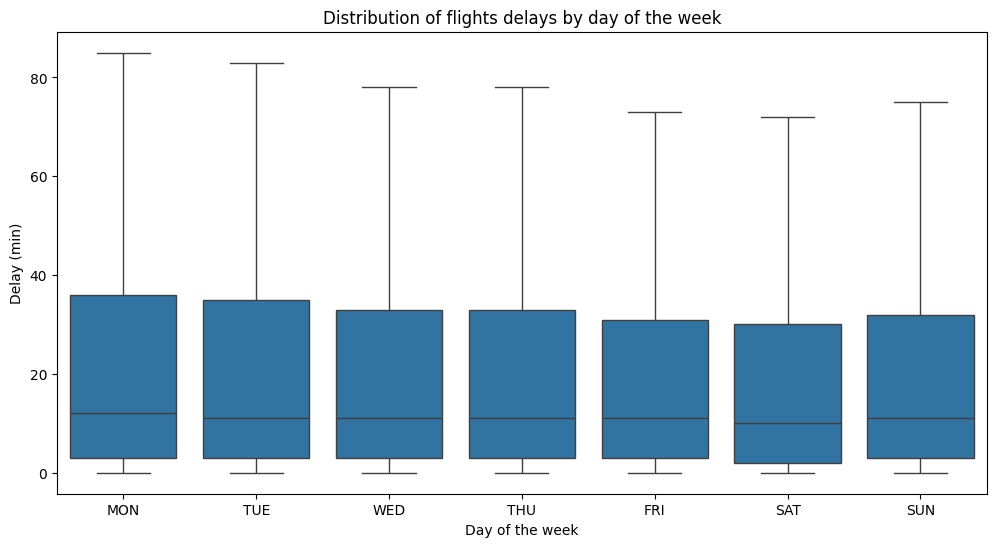

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='DAY_OF_WEEK',
    y='DEPARTURE_DELAY',
    data= df,
    order= days,
    showfliers= False  #hide emissions for readability
)

plt.title('Distribution of flights delays by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Delay (min)')
plt.show()

# The maximum value is not as shown in the table due to the limitation of emissions

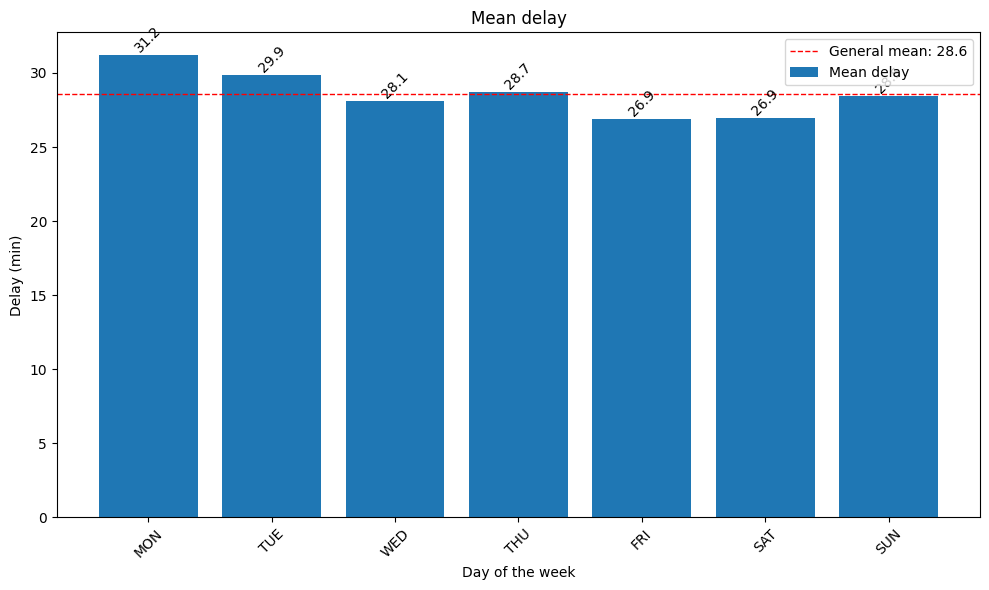

In [58]:
plt.figure(figsize=(10, 6))

bars = plt.bar(days, delays['mean'], label='Mean delay')

for i, v in enumerate(delays['mean']):
    plt.text(i, v, f'{v:.1f}', ha='center', va='bottom', fontsize=10, rotation=45)

mean_value = delays['mean'].mean()
plt.axhline(y=mean_value, color='r', linestyle='--', linewidth=1, label=f'General mean: {mean_value:.1f}')

plt.title('Mean delay')
plt.xlabel('Day of the week')
plt.ylabel('Delay (min)')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

Conclusion: The greatest flight delays on Monday and Tuesday may be due to increased load on the airline network after the weekend, when more business flights and passengers accumulate, as well as scheduled aircraft maintenance, which is often carried out on weekends, which temporarily reduces the available fleet of aircraft at the beginning of the week.

## Let's analyze the airline data

In [22]:
# takes full airline name
df = df.merge(airlines_df, left_on='AIRLINE', right_on='IATA_CODE', how='left')

df = df.rename(columns={'AIRLINE_x': 'AIRLINE_CODE', 'AIRLINE_y': 'AIRLINE_NAME'}) 

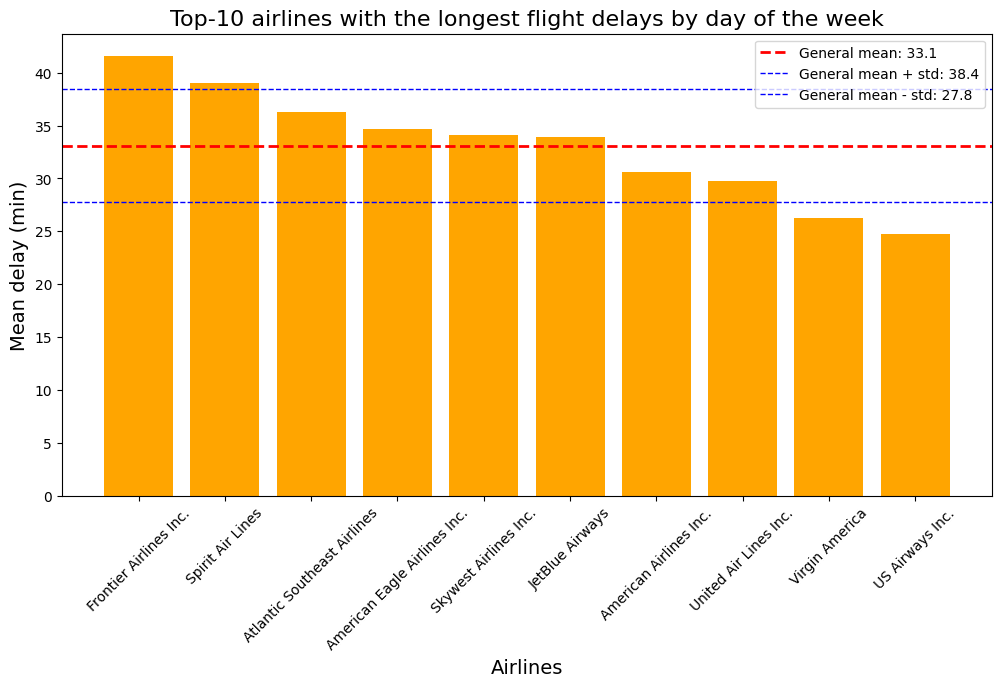

In [23]:
delays_airline = df.groupby('AIRLINE_NAME')['DEPARTURE_DELAY'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(delays_airline.index, delays_airline.values, color='orange')

mean_value = delays_airline.mean()
std = delays_airline.std()
plt.axhline(y=mean_value, color='r', linestyle='--', linewidth=2, label=f'General mean: {mean_value:.1f}')
plt.axhline(y=mean_value + std, color='b', linestyle='--', linewidth=1, label=f'General mean + std: {mean_value + std:.1f}')
plt.axhline(y=mean_value - std, color='b', linestyle='--', linewidth=1, label=f'General mean - std: {mean_value - std:.1f}')

plt.title("Top-10 airlines with the longest flight delays by day of the week", fontsize=16)
plt.xlabel("Airlines", fontsize=14)
plt.ylabel("Mean delay (min)", fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.show()

**Conclusion:** Frontier Airlines Inc. and Spirit Air Lines have the highest delays. This may indicate problems in their operational activities.

It is recommended to conduct a detailed analysis of the work of these airlines with the greatest delays in order to identify and eliminate the causes, as well as consider the possibility of implementing best practices from more efficient airlines.

## Analyze airports 

In [66]:
df = df.merge(airports_df, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='left')

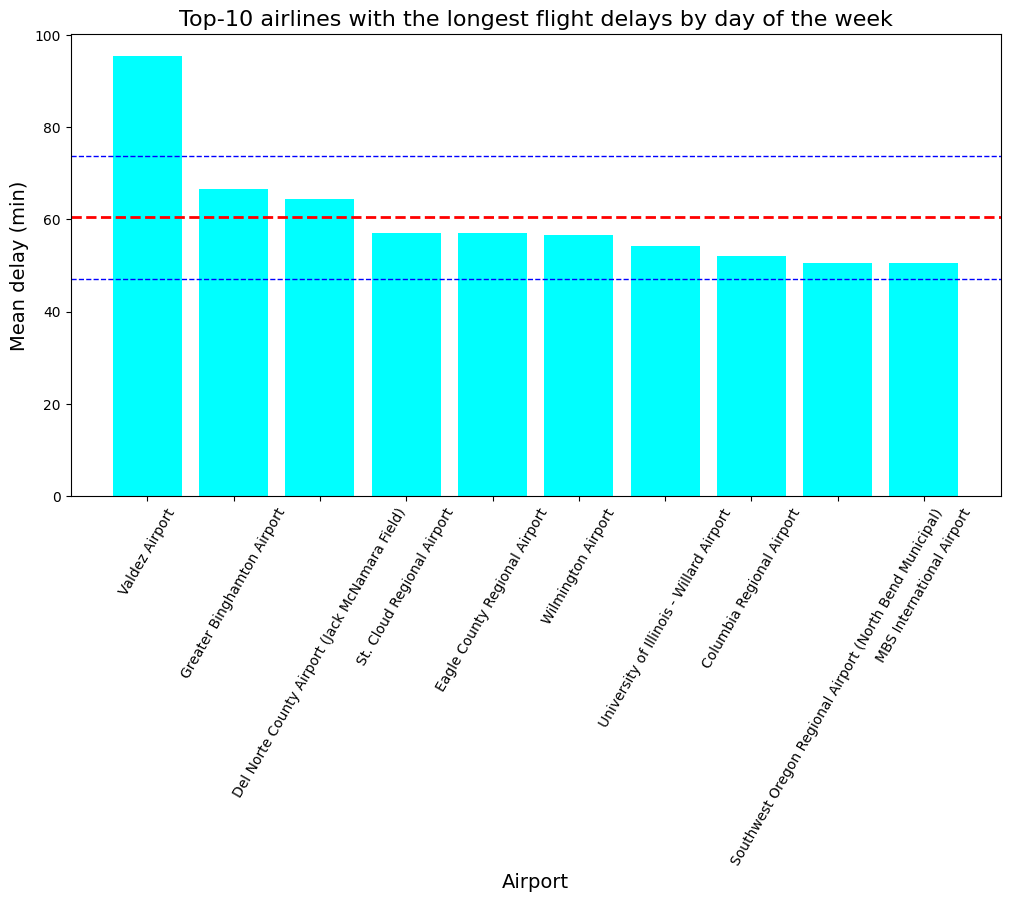

In [16]:
delays_airport = df.groupby('AIRPORT')['DEPARTURE_DELAY'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(delays_airport.index, delays_airport.values, color='cyan')
mean_value = delays_airport.mean()
std = delays_airport.std()
plt.axhline(y=mean_value, color='r', linestyle='--', linewidth=2, label=f'General mean: {mean_value:.1f}')
plt.axhline(y=mean_value + std, color='b', linestyle='--', linewidth=1, label=f'General mean + std: {mean_value + std:.1f}')
plt.axhline(y=mean_value - std, color='b', linestyle='--', linewidth=1, label=f'General mean - std: {mean_value - std:.1f}')

plt.title("Top-10 airlines with the longest flight delays by day of the week", fontsize=16)
plt.xlabel("Airport", fontsize=14)
plt.ylabel("Mean delay (min)", fontsize=14)
plt.xticks(rotation=60)
plt.show()

**Output:** We see that the biggest delays occur at the airport **Valdez Airport**. It is recommended to conduct a detailed analysis of the operation of this airport to identify and eliminate the causes of delays.

## Now we can check delays in combination airport and airline  

In [ ]:
# I will filter the dataset so that only flights related to our top 10 the worst airports and 10 airlines 
top_airports = np.array(delays_airport.index)
top_airlines = np.array(delays_airline.index)

filtered_df = df[
    df['AIRPORT'].isin(top_airports) &
    df['AIRLINE_NAME'].isin(top_airlines)
]

print(len(filtered_df['AIRPORT'].unique()))
print(len(filtered_df['AIRLINE_NAME'].unique()))

10
6


We can see, that some 4 airlines have no departures from our top-10 airports

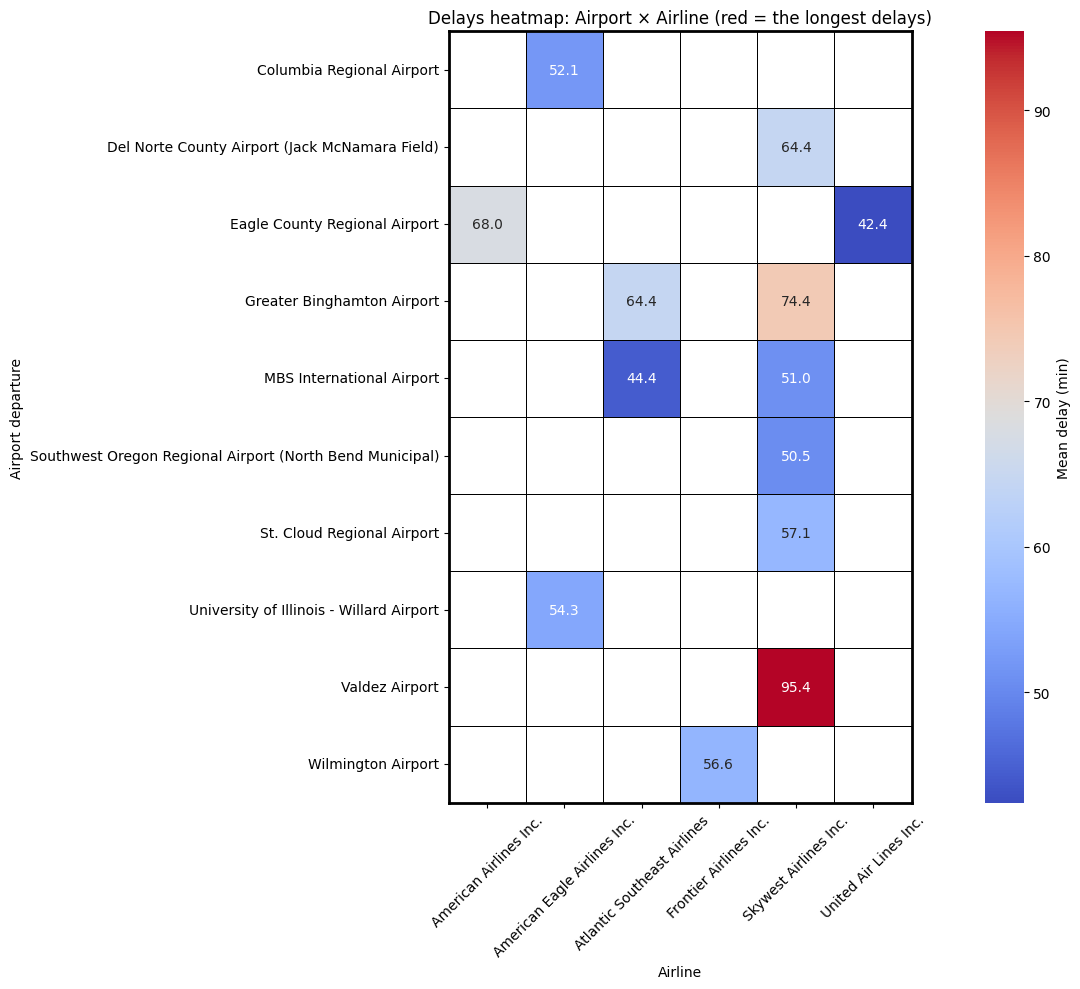

In [65]:
# making heatmap data
heatmap_data = filtered_df.groupby(['AIRPORT', 'AIRLINE_NAME'])['DEPARTURE_DELAY'].mean().unstack()
#heatmap_data = heatmap_data.fillna(0)

plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    heatmap_data,
    cmap='coolwarm',  # color map (red = the longest delays)
    annot=True,       # numbers
    fmt=".1f",    
    linewidths=0.5,
    cbar_kws={'label': 'Mean delay (min)'},
    linecolor = 'black',
    square= True
    
)

# making the black border around heatmap
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(2)

plt.title('Delays heatmap: Airport × Airline (red = the longest delays)')
plt.xlabel('Airline')
plt.ylabel('Airport departure')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Conclusion and recommendations on the analysis of flight delays**

Based on the analysis of the heatmap and statistical data, the following key observations can be made:

1. **Problematic operator**:
Despite its average position in the overall ranking (5th place), **SkyWest Airlines** demonstrates systematic delays at the 10 most problematic airports in the country. The situation at **Valdez Airport** is particularly alarming, where the airline's combined delay rate reaches critical levels.

2. **Critical point** :
**Valdez Airport** stands out as the most problematic node that requires special attention. Its figures are significantly higher than the average values for other airports.

3. **Hidden problems** :
The heat map revealed an important nuance that was not obvious from the general statistics - specific problematic airport-airline combinations that require a targeted approach.
